In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random

# for now this is defined here bc we use it to set up constants
def get_subpaths(path, length):
    ''' Given a path, return a set of all sub-paths of the specified length. '''
    return {tuple(path[i:i + length]) for i in range(len(path) - length + 1)}


################################# Set up all of our constants #################################

# Barriers can exist in any open hex, excluding the hexes right next to the reward ports
POSSIBLE_BARRIERS = np.arange(5, 48)
POSSIBLE_BARRIERS = POSSIBLE_BARRIERS[~np.isin(POSSIBLE_BARRIERS, [5, 6, 33, 38, 43, 47])]

# Minimum distance from port to critical choice point = 6 (including port hex)
ILLEGAL_CHOICE_POINTS_6 = [4, 6, 5, 11, 8, 10, 7, 9, 49, 38, 47, 32, 42, 27, 37, 46, 48, 43, 33, 39, 28, 44, 34, 23]

# Max straight path length to reward port = 6 hexes. (illegal paths are 7+)
MAX_STRAIGHT_PATH_TO_PORT = 6
STRAIGHT_PATHS_TO_PORTS = [[1, 4, 6, 8, 11, 14, 18, 22, 27, 32, 38, 49, 2], 
                  [1, 4, 5, 7, 9, 12, 15, 19, 23, 28, 33, 48, 3],
                  [2, 49, 47, 42, 46, 41, 45, 40, 44, 39, 43, 48, 3]]
# Max straight path length inside maze = 6 hexes. (illegal paths are 7+)
MAX_STRAIGHT_PATH_INSIDE_MAZE = 6
STRAIGHT_PATHS_INSIDE_MAZE = [[5, 7, 10, 13, 17, 21, 26, 31, 37, 42, 47],
                              [9, 12, 16, 20, 25, 30, 36, 41, 46],
                              [6, 8, 10, 13, 16, 20, 24, 29, 34, 39, 43],
                              [11, 14, 17, 21, 25, 30, 35, 40, 44],
                              [38, 32, 37, 31, 36, 30, 35, 29, 34, 28, 33],
                              [27, 22, 26, 21, 25, 20, 24, 19, 23]]

# Get all illegal straight paths to ports
illegal_straight_paths_list = []
for path in STRAIGHT_PATHS_TO_PORTS:
    for sub_path in get_subpaths(path, MAX_STRAIGHT_PATH_TO_PORT+1):
        illegal_straight_paths_list.append(sub_path)

# Store illegal straight paths as a set of tuples for O(1) lookup time
ILLEGAL_STRAIGHT_PATHS_TO_PORT = {tuple(path) for path in illegal_straight_paths_list}

# Get all illegal straight paths inside the maze
illegal_straight_paths_list = []
for path in STRAIGHT_PATHS_INSIDE_MAZE:
    for sub_path in get_subpaths(path, MAX_STRAIGHT_PATH_INSIDE_MAZE+1):
        illegal_straight_paths_list.append(sub_path)

# Store illegal straight paths as a set of tuples for O(1) lookup time
ILLEGAL_STRAIGHT_PATHS_INSIDE_MAZE = {tuple(path) for path in illegal_straight_paths_list}

################################# Define a bunch of functions #################################

def create_hex_maze():
    '''
    Use networkx to create a graph representing the empty hex maze before any barriers are added.
    
    Returns: a new networkx graph representing all of the hexes in the hex maze
    ''' 
    empty_hex_maze = nx.Graph()
    
    # Define all nodes and edges to create the empty maze
    add_edges_to_node(empty_hex_maze, 1, [4])
    add_edges_to_node(empty_hex_maze, 4, [1, 5, 6])
    add_edges_to_node(empty_hex_maze, 6, [4, 8])
    add_edges_to_node(empty_hex_maze, 5, [4, 7])
    add_edges_to_node(empty_hex_maze, 8, [6, 11, 10])
    add_edges_to_node(empty_hex_maze, 7, [5, 10, 9])
    add_edges_to_node(empty_hex_maze, 11, [8, 14])
    add_edges_to_node(empty_hex_maze, 10, [8, 7, 13])
    add_edges_to_node(empty_hex_maze, 9, [7, 12])
    add_edges_to_node(empty_hex_maze, 14, [11, 18, 17])
    add_edges_to_node(empty_hex_maze, 13, [10, 17, 16])
    add_edges_to_node(empty_hex_maze, 12, [9, 16, 15])
    add_edges_to_node(empty_hex_maze, 18, [14, 22])
    add_edges_to_node(empty_hex_maze, 17, [14, 13, 21])
    add_edges_to_node(empty_hex_maze, 16, [13, 12, 20])
    add_edges_to_node(empty_hex_maze, 15, [12, 19])
    add_edges_to_node(empty_hex_maze, 22, [18, 27, 26])
    add_edges_to_node(empty_hex_maze, 21, [17, 26, 25])
    add_edges_to_node(empty_hex_maze, 20, [16, 25, 24])
    add_edges_to_node(empty_hex_maze, 19, [15, 24, 23])
    add_edges_to_node(empty_hex_maze, 27, [22, 32])
    add_edges_to_node(empty_hex_maze, 26, [22, 21, 31])
    add_edges_to_node(empty_hex_maze, 25, [21, 20, 30])
    add_edges_to_node(empty_hex_maze, 24, [20, 19, 29])
    add_edges_to_node(empty_hex_maze, 23, [19, 28])
    add_edges_to_node(empty_hex_maze, 32, [27, 38, 37])
    add_edges_to_node(empty_hex_maze, 31, [26, 37, 36])
    add_edges_to_node(empty_hex_maze, 30, [25, 36, 35])
    add_edges_to_node(empty_hex_maze, 29, [24, 35, 34])
    add_edges_to_node(empty_hex_maze, 28, [23, 34, 33])
    add_edges_to_node(empty_hex_maze, 38, [32, 49])
    add_edges_to_node(empty_hex_maze, 37, [31, 32, 42])
    add_edges_to_node(empty_hex_maze, 36, [30, 31, 41])
    add_edges_to_node(empty_hex_maze, 35, [29, 30, 40])
    add_edges_to_node(empty_hex_maze, 34, [28, 29, 39])
    add_edges_to_node(empty_hex_maze, 33, [28, 48])
    add_edges_to_node(empty_hex_maze, 49, [2, 38, 47])
    add_edges_to_node(empty_hex_maze, 42, [37, 46, 47])
    add_edges_to_node(empty_hex_maze, 41, [36, 45, 46])
    add_edges_to_node(empty_hex_maze, 40, [35, 44, 45])
    add_edges_to_node(empty_hex_maze, 39, [34, 43, 44])
    add_edges_to_node(empty_hex_maze, 48, [3, 33, 43])
    add_edges_to_node(empty_hex_maze, 2, [49])
    add_edges_to_node(empty_hex_maze, 47, [49, 42])
    add_edges_to_node(empty_hex_maze, 46, [42, 41])
    add_edges_to_node(empty_hex_maze, 45, [41, 40])
    add_edges_to_node(empty_hex_maze, 44, [40, 39])
    add_edges_to_node(empty_hex_maze, 43, [39, 48])
    add_edges_to_node(empty_hex_maze, 3, [48])
    return empty_hex_maze
    

def add_edges_to_node(graph, node, edges):
    '''
    Add all edges to the specified node in the graph. 
    If the node does not yet exist in the graph, add the node.
    '''
    for edge in edges:
        graph.add_edge(node, edge)
        
def find_all_critical_choice_points(graph):
    '''
    Given a graph representing the hex maze, 
    find all critical choice points between reward ports 1, 2, and 3.
    
    Returns: a set of all critical choice points
    '''
    paths12 = list(nx.all_shortest_paths(graph, source=1, target=2))
    paths13 = list(nx.all_shortest_paths(graph, source=1, target=3))
    paths23 = list(nx.all_shortest_paths(graph, source=2, target=3))
    
    choice_points = set()
    # all choice points from port 1
    for path_a in paths12:
        for path_b in paths13:
            shared_path = [hex for hex in path_a if hex in path_b]
            choice_points.add(shared_path[-1])
    
    # all choice points from port 2
    for path_a in paths12:
        for path_b in paths23:
            shared_path = [hex for hex in path_a[::-1] if hex in path_b]
            choice_points.add(shared_path[-1])
            
    # all choice points from port 3
    for path_a in paths13:
        for path_b in paths23:
            shared_path = [hex for hex in path_a[::-1] if hex in path_b[::-1]]
            choice_points.add(shared_path[-1])
    return choice_points


def has_illegal_straight_path(graph):
    '''
    Given a graph of the hex maze, checks if there are any illegal straight paths.
    Returns: the (first) offending path, or False if none
    '''
    optimal_paths = []
    optimal_paths.extend(list(nx.all_shortest_paths(graph, source=1, target=2)))
    optimal_paths.extend(list(nx.all_shortest_paths(graph, source=1, target=3)))
    optimal_paths.extend(list(nx.all_shortest_paths(graph, source=2, target=3)))

    # We do 2 separate checks here beacause we may have different path length critera
    # for paths to reward ports vs inside the maze
    
    # First check all subpaths against illegal paths to a reward port
    subpaths1 = set()
    for path in optimal_paths:
        subpaths1.update(get_subpaths(path, MAX_STRAIGHT_PATH_TO_PORT+1))

    for path in subpaths1:
        if path in ILLEGAL_STRAIGHT_PATHS_TO_PORT:
            return path # (equivalent to returning True)
        
    # Now check all subpaths against illegal paths inside the maze
    subpaths2 = set()
    for path in optimal_paths:
        subpaths2.update(get_subpaths(path, MAX_STRAIGHT_PATH_INSIDE_MAZE+1))

    for path in subpaths2:
        if path in ILLEGAL_STRAIGHT_PATHS_INSIDE_MAZE:
            return path # (equivalent to returning True)
    
    # If we did all of those checks and found no straight paths, we're good to go!
    return False


def is_valid_maze(graph, complain=False):
    '''
    Given a graph representing a possible hex maze configuration, check if it is valid 
    using the following criteria: 
    - there are no unreachable hexes (includes that all reward ports are reachable)
    - path lengths between reward ports are between 15-25 hexes
    - all critical choice points are >=6 hexes away from a reward port
    - there are a maximum of 3 critical choice points
    - no straight paths >MAX_STRAIGHT_PATH_TO_PORT hexes to reward port (including port hex)
    - no straight paths >STRAIGHT_PATHS_INSIDE_MAZE in middle of maze
    
    Optional argument complain (defaults to False):
    - When True: If our maze configuration is invalid, print out the reason why.
    
    Returns: True if the hex maze is valid, False otherwise
    '''

    # Make sure all (non-barrier) hexes are reachable
    if not nx.is_connected(graph):
        if complain:
            print("BAD MAZE: At least one (non-barrier) hex is unreachable")
        return False
    
    # Make sure path lengths are between 15-25
    len12 = nx.shortest_path_length(graph, source=1, target=2)
    len13 = nx.shortest_path_length(graph, source=1, target=3)
    len23 = nx.shortest_path_length(graph, source=2, target=3)
    reward_port_lengths = [len12, len13, len23]
    if min(reward_port_lengths) <= 13:
        if complain:
            print("BAD MAZE: Path between reward ports is too short (<=13)")
        return False
    if max(reward_port_lengths) - min(reward_port_lengths) < 4:
        if complain:
            print("BAD MAZE: Distance difference in reward port paths is too small (<4)")
        return False
    if max(reward_port_lengths) > 25:
        if complain:
            print("BAD MAZE: Path between reward ports is too long (>25)")
        return False

    # Make sure all critical choice points are >=6 hexes away from a reward port
    choice_points = find_all_critical_choice_points(graph)
    if any(hex in ILLEGAL_CHOICE_POINTS_6 for hex in choice_points):
        if complain:
            print("BAD MAZE: Choice point <6 hexes away from reward port")
        return False
    
    # Make sure there are not more than 3 critical choice points
    if len(choice_points) > 3:
        if complain:
            print("BAD MAZE: More than 3 critical choice points")
        return False
    
    # Make sure there are no straight paths
    illegal_path = has_illegal_straight_path(graph)
    if illegal_path:
        if complain:
            print("BAD MAZE: Straight path ", illegal_path)
        return False
    
    return True

Use a naive generation approach to generate an allowable hex maze configuration (randomly generate possible mazes until we get a good one)

BAD MAZE: At least one (non-barrier) hex is unreachable
BAD MAZE: Distance difference in reward port paths is too small (<4)
BAD MAZE: At least one (non-barrier) hex is unreachable
BAD MAZE: At least one (non-barrier) hex is unreachable
BAD MAZE: At least one (non-barrier) hex is unreachable
BAD MAZE: At least one (non-barrier) hex is unreachable
BAD MAZE: Path between reward ports is too short (<=13)
BAD MAZE: At least one (non-barrier) hex is unreachable
BAD MAZE: Path between reward ports is too short (<=13)
BAD MAZE: At least one (non-barrier) hex is unreachable
BAD MAZE: At least one (non-barrier) hex is unreachable
BAD MAZE: At least one (non-barrier) hex is unreachable
BAD MAZE: At least one (non-barrier) hex is unreachable
BAD MAZE: At least one (non-barrier) hex is unreachable
BAD MAZE: At least one (non-barrier) hex is unreachable
BAD MAZE: At least one (non-barrier) hex is unreachable
BAD MAZE: At least one (non-barrier) hex is unreachable
BAD MAZE: At least one (non-barrier

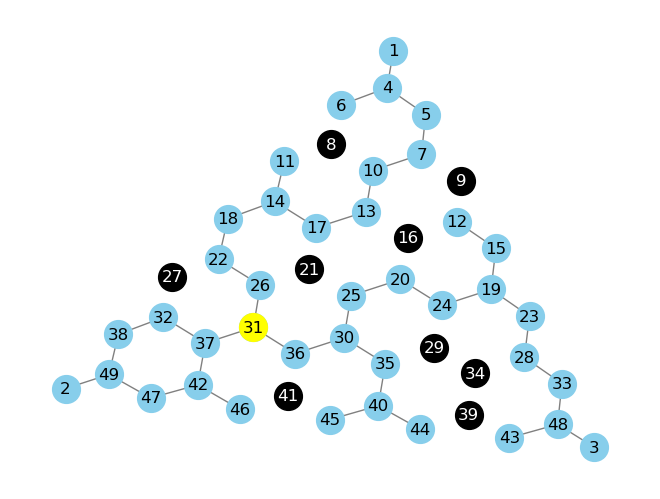

In [9]:
# Create the empty hex maze
empty_hex_maze = create_hex_maze()
barriers = []

# Generate a set of 9 random barriers until we get a good maze
is_good_maze = False
while not is_good_maze:
    # Start with an empty hex maze (no barriers)
    G = empty_hex_maze.copy()

    # Randomly select 9 barriers
    barriers = np.random.choice(POSSIBLE_BARRIERS, size=9, replace=False)
    
    # Add the barriers to the empty maze
    for barrier in barriers:
        G.remove_node(barrier)
        
    # Check if this is a good maze
    is_good_maze = is_valid_maze(G, complain=True)

# Print the barriers we chose
print("Barriers:", barriers)
# Once we get a good maze, print some stats about it
print("Shortest path between 1 and 2:", nx.shortest_path(G, source=1, target=2))
print("Length of path:", len(nx.shortest_path(G, source=1, target=2)))
print("Shortest path between 1 and 3:", nx.shortest_path(G, source=1, target=3))
print("Length of path:", len(nx.shortest_path(G, source=1, target=3)))
print("Shortest path between 2 and 3:", nx.shortest_path(G, source=2, target=3))
print("Length of path:", len(nx.shortest_path(G, source=2, target=3)))

print("Critical choice point(s):")
choice_points = find_all_critical_choice_points(G)
print(choice_points)

# Get the graph layout of the original maze
pos = nx.kamada_kawai_layout(empty_hex_maze)

# Draw the available hexes using this layout
nx.draw(G, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=400)

# Add the barriers in black
nx.draw_networkx_nodes(empty_hex_maze, pos, nodelist={b: b for b in barriers}, node_color='black', node_size=400)   
nx.draw_networkx_labels(empty_hex_maze, pos, labels={b: b for b in barriers}, font_color='white')

# Make the choice point(s) yellow
for choice_point in choice_points:
    nx.draw_networkx_nodes(empty_hex_maze, pos, nodelist=[choice_point], node_color='yellow', node_size=400)
        
plt.show()

In [ ]:
from tqdm import tqdm

def generate_good_maze():
    '''
    Keep generating hex mazes until we get a good one! 

    Returns: the set of barriers for the good hex maze
    '''
    # Create the empty hex maze
    start_maze = create_hex_maze()
    barriers = set()

    # Generate a set of 9 random barriers until we get a good maze
    is_good_maze = False
    while not is_good_maze:
        # Start with an empty hex maze (no barriers)
        test_maze = start_maze.copy()

        # Randomly select 9 barriers
        barriers = set(np.random.choice(POSSIBLE_BARRIERS, size=9, replace=False))

        # Add the barriers to the empty maze
        for barrier in barriers:
            test_maze.remove_node(barrier)

        # Check if this is a good maze
        is_good_maze = is_valid_maze(test_maze)

    return barriers


def plot_hex_maze(barriers):
    ''' Given a set of barriers specifying a hex maze, plot the maze! '''
    
    # create an empty maze for graph layout
    base_hex_maze = create_hex_maze()
    
    # create our actual maze
    maze = base_hex_maze.copy()
    for barrier in barriers:
        maze.remove_node(barrier)

    # Get the graph layout of the original maze
    pos = nx.kamada_kawai_layout(base_hex_maze)

    # Draw the available hexes in our maze using this layout
    nx.draw(maze, pos, with_labels=True, node_color='skyblue', edge_color='gray', node_size=400)

    # Add the barriers in black
    nx.draw_networkx_nodes(base_hex_maze, pos, nodelist={b: b for b in barriers}, node_color='black', node_size=400)   
    nx.draw_networkx_labels(base_hex_maze, pos, labels={b: b for b in barriers}, font_color='white')

    # Make the choice point(s) yellow
    choice_points = find_all_critical_choice_points(maze)
    for choice_point in choice_points:
        nx.draw_networkx_nodes(base_hex_maze, pos, nodelist=[choice_point], node_color='yellow', node_size=400)
    
    plt.show()


lots_of_good_mazes = set()
number_of_valid_configs = []

# run it 10,000 times! weeeeeeee
for i in tqdm(range(10000)):
    maze = frozenset(generate_good_maze())
    lots_of_good_mazes.add(maze)
    
    if i % 100 == 0:
        num_valid = len(lots_of_good_mazes)
        number_of_valid_configs.append(num_valid)
        print(f"After {i} good mazes, {num_valid} are unique.")



  0%|                                         | 2/10000 [00:00<49:18,  3.38it/s]

After 0 good mazes, 1 are unique.


  1%|▍                                      | 102/10000 [00:27<33:41,  4.90it/s]

After 100 good mazes, 101 are unique.


  2%|▋                                    | 201/10000 [00:55<1:11:16,  2.29it/s]

After 200 good mazes, 200 are unique.


  3%|█▏                                     | 301/10000 [01:27<55:04,  2.94it/s]

After 300 good mazes, 300 are unique.


  4%|█▌                                     | 402/10000 [02:00<41:04,  3.89it/s]

After 400 good mazes, 400 are unique.


  5%|█▉                                     | 501/10000 [02:31<37:55,  4.17it/s]

After 500 good mazes, 499 are unique.


  6%|██▏                                  | 601/10000 [03:02<1:26:56,  1.80it/s]

After 600 good mazes, 597 are unique.


  7%|██▋                                    | 704/10000 [03:35<38:21,  4.04it/s]

After 700 good mazes, 696 are unique.


  8%|███▏                                   | 803/10000 [04:06<39:08,  3.92it/s]

After 800 good mazes, 796 are unique.


  9%|███▌                                   | 903/10000 [04:40<55:54,  2.71it/s]

After 900 good mazes, 895 are unique.


 10%|███▊                                  | 1002/10000 [05:14<28:20,  5.29it/s]

After 1000 good mazes, 994 are unique.


 11%|████▏                                 | 1102/10000 [05:48<29:43,  4.99it/s]

After 1100 good mazes, 1092 are unique.


 12%|████▌                                 | 1202/10000 [06:18<30:30,  4.81it/s]

After 1200 good mazes, 1191 are unique.


 13%|████▉                                 | 1301/10000 [06:53<57:07,  2.54it/s]

After 1300 good mazes, 1286 are unique.


 14%|█████▎                                | 1402/10000 [07:25<31:19,  4.58it/s]

After 1400 good mazes, 1384 are unique.


 15%|█████▋                                | 1501/10000 [07:59<21:20,  6.63it/s]

After 1500 good mazes, 1482 are unique.


 16%|██████                                | 1602/10000 [08:34<46:42,  3.00it/s]

After 1600 good mazes, 1576 are unique.


 17%|██████▍                               | 1702/10000 [09:05<32:59,  4.19it/s]

After 1700 good mazes, 1669 are unique.


 18%|██████▊                               | 1802/10000 [09:36<37:40,  3.63it/s]

After 1800 good mazes, 1765 are unique.


 19%|███████▏                              | 1903/10000 [10:00<46:27,  2.90it/s]

After 1900 good mazes, 1862 are unique.


 20%|███████▌                              | 2001/10000 [10:33<40:40,  3.28it/s]

After 2000 good mazes, 1960 are unique.


 21%|███████▉                              | 2104/10000 [11:00<20:23,  6.45it/s]

After 2100 good mazes, 2058 are unique.


 22%|████████▎                             | 2202/10000 [11:30<50:07,  2.59it/s]

After 2200 good mazes, 2152 are unique.


 23%|████████▋                             | 2302/10000 [12:02<24:33,  5.22it/s]

After 2300 good mazes, 2248 are unique.


 24%|█████████▏                            | 2403/10000 [12:36<45:42,  2.77it/s]

After 2400 good mazes, 2344 are unique.


 25%|█████████▌                            | 2501/10000 [13:05<41:44,  2.99it/s]

After 2500 good mazes, 2441 are unique.


 26%|█████████▉                            | 2602/10000 [13:33<31:08,  3.96it/s]

After 2600 good mazes, 2537 are unique.


 27%|█████████▋                          | 2701/10000 [14:06<1:03:16,  1.92it/s]

After 2700 good mazes, 2633 are unique.


 28%|██████████▋                           | 2804/10000 [14:32<30:41,  3.91it/s]

After 2800 good mazes, 2730 are unique.


 29%|███████████                           | 2902/10000 [15:05<39:10,  3.02it/s]

After 2900 good mazes, 2828 are unique.


 30%|███████████▍                          | 3002/10000 [15:37<45:49,  2.54it/s]

After 3000 good mazes, 2923 are unique.


 31%|███████████▊                          | 3103/10000 [16:06<26:14,  4.38it/s]

After 3100 good mazes, 3015 are unique.


 32%|████████████▏                         | 3205/10000 [16:37<25:52,  4.38it/s]

After 3200 good mazes, 3107 are unique.


 33%|████████████▌                         | 3302/10000 [17:08<24:12,  4.61it/s]

After 3300 good mazes, 3199 are unique.


 34%|████████████▉                         | 3403/10000 [17:42<40:54,  2.69it/s]

After 3400 good mazes, 3295 are unique.


 35%|█████████████▎                        | 3502/10000 [18:11<47:20,  2.29it/s]

After 3500 good mazes, 3393 are unique.


 36%|█████████████▋                        | 3602/10000 [18:43<24:21,  4.38it/s]

After 3600 good mazes, 3485 are unique.


 37%|██████████████                        | 3702/10000 [19:18<49:55,  2.10it/s]

After 3700 good mazes, 3578 are unique.


 38%|██████████████▍                       | 3801/10000 [19:49<46:16,  2.23it/s]

After 3800 good mazes, 3676 are unique.


 39%|██████████████▊                       | 3902/10000 [20:21<37:56,  2.68it/s]

After 3900 good mazes, 3770 are unique.


 40%|███████████████▏                      | 4003/10000 [20:51<27:47,  3.60it/s]

After 4000 good mazes, 3862 are unique.


 41%|███████████████▌                      | 4102/10000 [21:24<35:58,  2.73it/s]

After 4100 good mazes, 3955 are unique.


 42%|███████████████▉                      | 4202/10000 [21:55<18:49,  5.14it/s]

After 4200 good mazes, 4045 are unique.


 43%|████████████████▎                     | 4301/10000 [22:24<23:13,  4.09it/s]

After 4300 good mazes, 4140 are unique.


 44%|████████████████▋                     | 4402/10000 [22:56<33:24,  2.79it/s]

After 4400 good mazes, 4236 are unique.


 45%|█████████████████                     | 4503/10000 [23:23<30:58,  2.96it/s]

After 4500 good mazes, 4324 are unique.


 46%|█████████████████▍                    | 4602/10000 [23:53<16:02,  5.61it/s]

After 4600 good mazes, 4414 are unique.


 47%|█████████████████▊                    | 4702/10000 [24:22<18:33,  4.76it/s]

After 4700 good mazes, 4505 are unique.


 48%|██████████████████▏                   | 4802/10000 [24:53<27:09,  3.19it/s]

After 4800 good mazes, 4591 are unique.


 48%|██████████████████▍                   | 4841/10000 [25:07<50:24,  1.71it/s]

In [25]:
print(len(lots_of_good_mazes))
for thing in lots_of_good_mazes:
    print(sorted(thing))

498
[7, 13, 16, 18, 20, 30, 37, 39, 46]
[13, 19, 22, 23, 26, 30, 39, 42, 46]
[9, 11, 16, 21, 27, 30, 34, 39, 42]
[7, 11, 17, 19, 24, 30, 32, 39, 46]
[8, 9, 20, 23, 26, 27, 35, 37, 40]
[8, 10, 15, 21, 23, 27, 30, 39, 41]
[7, 9, 15, 18, 20, 30, 37, 44, 46]
[14, 17, 23, 24, 28, 30, 37, 44, 46]
[11, 17, 23, 24, 30, 37, 42, 44, 46]
[10, 14, 19, 25, 35, 37, 39, 42, 46]
[7, 14, 17, 20, 23, 27, 30, 44, 46]
[10, 11, 13, 19, 25, 30, 39, 42, 46]
[13, 18, 23, 24, 30, 37, 39, 44, 46]
[7, 13, 22, 24, 28, 30, 42, 44, 46]
[13, 15, 22, 24, 25, 27, 29, 37, 45]
[7, 14, 20, 28, 30, 37, 44, 45, 46]
[7, 14, 16, 25, 34, 37, 41, 44, 45]
[13, 15, 18, 21, 22, 30, 34, 42, 44]
[10, 11, 19, 21, 23, 27, 30, 39, 41]
[8, 10, 15, 18, 25, 34, 35, 37, 41]
[7, 9, 16, 18, 20, 30, 37, 44, 46]
[7, 14, 17, 20, 23, 28, 34, 36, 46]
[8, 13, 18, 23, 24, 27, 30, 39, 46]
[8, 9, 12, 21, 25, 28, 29, 32, 41]
[7, 14, 20, 25, 28, 31, 37, 42, 44]
[9, 17, 19, 22, 24, 27, 30, 39, 46]
[17, 19, 22, 23, 24, 27, 30, 42, 44]
[10, 11, 21, 23, 2